In [1]:
# packages for routine python code
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
# packages for machine learning
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.datasets import fetch_openml
# common utils
import time
import timeit
from tqdm.autonotebook import tqdm
# packages for deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision 
from torchvision import transforms

C:\Users\Weizhe\AppData\Local\Temp\ipykernel_21980\395307483.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### resource: https://d2l.ai/index.html

In [20]:
!pip install d2l==1.0.0-alpha1.post0

Defaulting to user installation because normal site-packages is not writeable
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827633 sha256=20cbe7c951dcd3e0b27eece22418d733a815c9119abaf449627785447dafae48
  Stored in directory: c:\users\weizhe\appdata\local\pip\cache\wheels\af\2b\30\5e78b8b9599f2a2286a582b8da80594f654bf0e18d825a4405
Successfully built gym


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append("/content/drive/MyDrive")

In [2]:
from mpdl import train_simple_network
from mpdl import train_network

In [3]:
# setup for matplotlib in Jupyter Notebook
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

C:\Users\Weizhe\AppData\Local\Temp\ipykernel_21980\1153496997.py:4: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [4]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

In [5]:
torch.backends.cudnn.deterministic=True
set_seed(42)

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [7]:
!nvidia-smi

Sun Oct 16 21:12:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.40       Driver Version: 516.40       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   33C    P8    23W / 350W |    948MiB / 24576MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## LeNet

In this section, we will introduce *LeNet*,
among the first published CNNs
to capture wide attention for its performance on computer vision tasks.
The model was introduced by (and named for) Yann LeCun,
then a researcher at AT&T Bell Labs,
for the purpose of recognizing handwritten digits in images :cite:`LeCun.Bottou.Bengio.ea.1998`.
This work represented the culmination
of a decade of research developing the technology.
In 1989, LeCun's team published the first study to successfully
train CNNs via backpropagation :cite:`LeCun.Boser.Denker.ea.1989`.

At the time LeNet achieved outstanding results
matching the performance of support vector machines,
then a dominant approach in supervised learning, achieving an error rate of less than 1% per digit.
LeNet was eventually adapted to recognize digits
for processing deposits in ATM machines.
To this day, some ATMs still run the code
that Yann LeCun and his colleague Leon Bottou wrote in the 1990s!

At a high level, (**LeNet (LeNet-5) consists of two parts:
(i) a convolutional encoder consisting of two convolutional layers; and
(ii) a dense block consisting of three fully connected layers**);
The architecture is summarized in :numref:`img_lenet`.

![Data flow in LeNet. The input is a handwritten digit, the output a probability over 10 possible outcomes.](http://d2l.ai/_images/lenet.svg)
:label:`img_lenet`

The basic units in each convolutional block
are a convolutional layer, a sigmoid activation function,
and a subsequent average pooling operation.
Note that while ReLUs and max-pooling work better,
these discoveries had not yet been made at the time.
Each convolutional layer uses a $5\times 5$ kernel
and a sigmoid activation function.
These layers map spatially arranged inputs
to a number of two-dimensional feature maps, typically
increasing the number of channels.
The first convolutional layer has 6 output channels,
while the second has 16.
Each $2\times2$ pooling operation (stride 2)
reduces dimensionality by a factor of $4$ via spatial downsampling.
The convolutional block emits an output with shape given by
(batch size, number of channel, height, width).

In order to pass output from the convolutional block
to the dense block,
we must flatten each example in the minibatch.
In other words, we take this four-dimensional input and transform it
into the two-dimensional input expected by fully connected layers:
as a reminder, the two-dimensional representation that we desire uses the first dimension to index examples in the minibatch
and the second to give the flat vector representation of each example.
LeNet's dense block has three fully connected layers,
with 120, 84, and 10 outputs, respectively.
Because we are still performing classification,
the 10-dimensional output layer corresponds
to the number of possible output classes.

In [ ]:
!pwd

/content


In [ ]:
LeNet = nn.Sequential(
    nn.Conv2d(3, 6, kernel_size=5, padding=2),
    #nn.Sigmoid(),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    #nn.Sigmoid(),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5, 120),
    #nn.Sigmoid(),
    nn.ReLU(),
    nn.Linear(120, 84),
    #nn.Sigmoid(),
    nn.ReLU(),
    nn.Linear(84, 10)
)

We take some liberty in the reproduction of LeNet insofar as we replace the Gaussian activation layer by
a softmax layer. This greatly simplifies the implementation, not the least due to the
fact that the Gaussian decoder is rarely used nowadays. Other than that, this network matches
the original LeNet-5 architecture.

Let's see what happens inside the network. By passing a
single-channel (black and white)
$28 \times 28$ image through the network
and printing the output shape at each layer,
we can [**inspect the model**] to make sure
that its operations line up with
what we expect from :numref:`img_lenet_vert`.

![Compressed notation for LeNet-5.](http://d2l.ai/_images/lenet-vert.svg)
:label:`img_lenet_vert`

In [ ]:
def print_dim(model, input_size):
  X = torch.rand(size=(1, 1, input_size, input_size), dtype=torch.float32)
  for layer in model:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

In [ ]:
mnist_data_train = torchvision.datasets.MNIST("./", train=True, download=True, transform=transforms.ToTensor())
mnist_data_test = torchvision.datasets.MNIST("./", train=False, download=True, transform=transforms.ToTensor())
mnist_train_loader = DataLoader(mnist_data_train, batch_size=32, shuffle=True)
mnist_test_loader = DataLoader(mnist_data_test, batch_size=32)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
mnist_data_train[0][0].shape

torch.Size([1, 28, 28])

In [ ]:
x, y = next(iter(mnist_train_loader))

In [ ]:
x.shape

torch.Size([32, 1, 28, 28])

In [ ]:
y

tensor([1, 8, 4, 0, 3, 6, 9, 6, 1, 1, 9, 8, 1, 0, 6, 9, 0, 8, 5, 0, 0, 8, 6, 1,
        2, 6, 6, 4, 1, 5, 8, 2])

In [ ]:
print_dim(LeNet, 28)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
ReLU output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
ReLU output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
ReLU output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
ReLU output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [ ]:
class LeNet5_MNIST(nn.Module):
   def __init__(self):
       super().__init__()
       self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
       self.conv2 = nn.Conv2d(6, 16, 5)
       self.fc1 = nn.Linear(16*5*5, 120)
       self.fc2 = nn.Linear(120, 84)
       self.fc3 = nn.Linear(84, 10)
       
   def forward(self, x):
       #x = x.unsqueeze(1)
       x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
       x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
       x = x.view(-1, self.num_flat_features(x))
       x = F.relu(self.fc1(x))
       x = F.relu(self.fc2(x))
       x = self.fc3(x)
       return x
   
   def num_flat_features(self, x):
       size = x.size()[1:]
       num_features = 1
       for s in size:
           num_features *= s
       return num_features

In [ ]:
lenet_model = LeNet5_MNIST()

In [ ]:
loss_func = nn.CrossEntropyLoss()
cnn_results = train_simple_network(lenet_model, loss_func, mnist_train_loader, val_loader=mnist_test_loader, 
                                   score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10, lr=0.001)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

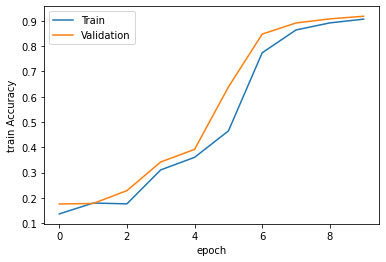

In [ ]:
sns.lineplot(x='epoch', y='train Accuracy', data=cnn_results, label='Train')
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_results, label='Validation')

In [ ]:
loss_func = nn.CrossEntropyLoss()
cnn_results = train_network(LeNet, loss_func, mnist_train_loader, val_loader=mnist_test_loader, 
                                   score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

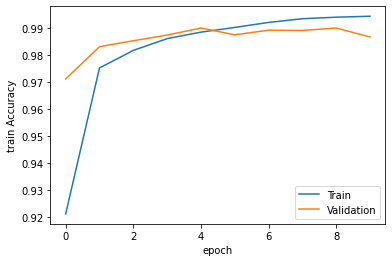

In [ ]:
sns.lineplot(x='epoch', y='train Accuracy', data=cnn_results, label='Train')
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_results, label='Validation')

In [ ]:
cnn_results

,epoch,total time,train loss,val loss,train Accuracy,val Accuracy
0,0,11.021655,138511.223793,23011.086044,0.108400,0.1135
1,1,21.877354,138080.424126,23012.347080,0.112367,0.1135
2,2,32.755715,138080.645706,23010.632702,0.112367,0.1135
3,3,43.699604,138083.168533,23010.794548,0.112367,0.1135
4,4,54.652137,138083.722168,23011.058559,0.112367,0.1135
5,5,65.565668,138084.615074,23010.240746,0.112367,0.1135
6,6,76.476085,138084.938858,23010.311512,0.112367,0.1135
7,7,87.353263,138082.252884,23010.444962,0.112333,0.1135
8,8,98.310208,138084.896149,23010.748940,0.112367,0.1135
9,9,109.265840,138083.257858,23010.425873,0.112367,0.1135


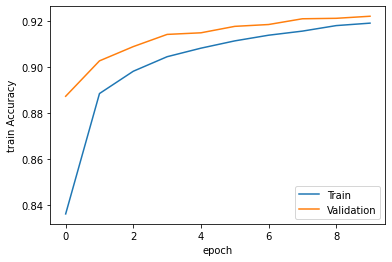

In [ ]:
sns.lineplot(x='epoch', y='train Accuracy', data=cnn_results, label='Train')
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_results, label='Validation')

## AlexNet

The first modern CNN :cite:`Krizhevsky.Sutskever.Hinton.2012`, named
*AlexNet* after one of its inventors, Alex Krizhevsky, is largely an evolutionary improvement
over LeNet. It achieved excellent performance in the 2012 ImageNet challenge.

Interestingly in the lowest layers of the network,
the model learned feature extractors that resembled some traditional filters.
:numref:`fig_filters`
shows lower-level image descriptors.
Higher layers in the network might build upon these representations
to represent larger structures, like eyes, noses, blades of grass, and so on.
Even higher layers might represent whole objects
like people, airplanes, dogs, or frisbees.
Ultimately, the final hidden state learns a compact representation
of the image that summarizes its contents
such that data belonging to different categories can be easily separated.

AlexNet (2012) and its precursor LeNet (1995) share many architectural elements. This begs the question: why did it take so long?
A key difference is that over the past two decades, the amount of data and computing power available had increased significantly. As such AlexNet was much larger: it was trained on much more data, and on much faster GPUs, compared to the CPUs available in 1995.

AlexNet, which employed an 8-layer CNN,
won the ImageNet Large Scale Visual Recognition Challenge 2012
by a large margin :cite:`Russakovsky.Deng.Huang.ea.2013`.
This network showed, for the first time,
that the features obtained by learning can transcend manually-designed features, breaking the previous paradigm in computer vision.

The architectures of AlexNet and LeNet are strikingly similar,
as :numref:`fig_alexnet` illustrates.
Note that we provide a slightly streamlined version of AlexNet
removing some of the design quirks that were needed in 2012
to make the model fit on two small GPUs.

![From LeNet (left) to AlexNet (right).](http://d2l.ai/_images/alexnet.svg)
:label:`fig_alexnet`

There are also significant differences between AlexNet and LeNet.
First, AlexNet is much deeper than the comparatively small LeNet5.
AlexNet consists of eight layers: five convolutional layers,
two fully connected hidden layers, and one fully connected output layer.
Second, AlexNet used the ReLU instead of the sigmoid
as its activation function. Let's delve into the details below.

### Architecture

In AlexNet's first layer, the convolution window shape is $11\times11$.
Since the images in ImageNet are eight times higher and wider
than the MNIST images,
objects in ImageNet data tend to occupy more pixels with more visual detail.
Consequently, a larger convolution window is needed to capture the object.
The convolution window shape in the second layer
is reduced to $5\times5$, followed by $3\times3$.
In addition, after the first, second, and fifth convolutional layers,
the network adds max-pooling layers
with a window shape of $3\times3$ and a stride of 2.
Moreover, AlexNet has ten times more convolution channels than LeNet.

After the last convolutional layer, there are two huge fully connected layers
with 4096 outputs.
These layers require nearly 1GB model parameters.
Due to the limited memory in early GPUs,
the original AlexNet used a dual data stream design,
so that each of their two GPUs could be responsible
for storing and computing only its half of the model.
Fortunately, GPU memory is comparatively abundant now,
so we rarely need to break up models across GPUs these days
(our version of the AlexNet model deviates
from the original paper in this aspect).

### Activation Functions

Besides, AlexNet changed the sigmoid activation function to a simpler ReLU activation function. On the one hand, the computation of the ReLU activation function is simpler. For example, it does not have the exponentiation operation found in the sigmoid activation function.
 On the other hand, the ReLU activation function makes model training easier when using different parameter initialization methods. This is because, when the output of the sigmoid activation function is very close to 0 or 1, the gradient of these regions is almost 0, so that backpropagation cannot continue to update some of the model parameters. In contrast, the gradient of the ReLU activation function in the positive interval is always 1 (:numref:`subsec_activation-functions`). Therefore, if the model parameters are not properly initialized, the sigmoid function may obtain a gradient of almost 0 in the positive interval, so that the model cannot be effectively trained.

### Capacity Control and Preprocessing

AlexNet controls the model complexity of the fully connected layer
by dropout (:numref:`sec_dropout`),
while LeNet only uses weight decay.
To augment the data even further, the training loop of AlexNet
added a great deal of image augmentation,
such as flipping, clipping, and color changes.
This makes the model more robust and the larger sample size effectively reduces overfitting.
We will discuss data augmentation in greater detail in :numref:`sec_image_augmentation`. See also :cite:`Buslaev.Iglovikov.Khvedchenya.ea.2020` for an in-depth review of such preprocessing steps.


In [ ]:
AlexNet = nn.Sequential(
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
    nn.Linear(6400, 4096), nn.ReLU(), nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(p=0.5),
    nn.Linear(4096, 10)
)

In [ ]:
print_dim(AlexNet, 224)

Conv2d output shape: 	 torch.Size([1, 96, 54, 54])
ReLU output shape: 	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape: 	 torch.Size([1, 96, 26, 26])
Conv2d output shape: 	 torch.Size([1, 256, 26, 26])
ReLU output shape: 	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape: 	 torch.Size([1, 256, 12, 12])
Conv2d output shape: 	 torch.Size([1, 384, 12, 12])
ReLU output shape: 	 torch.Size([1, 384, 12, 12])
Conv2d output shape: 	 torch.Size([1, 384, 12, 12])
ReLU output shape: 	 torch.Size([1, 384, 12, 12])
Conv2d output shape: 	 torch.Size([1, 256, 12, 12])
ReLU output shape: 	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape: 	 torch.Size([1, 256, 5, 5])
Flatten output shape: 	 torch.Size([1, 6400])
Linear output shape: 	 torch.Size([1, 4096])
ReLU output shape: 	 torch.Size([1, 4096])
Dropout output shape: 	 torch.Size([1, 4096])
Linear output shape: 	 torch.Size([1, 4096])
ReLU output shape: 	 torch.Size([1, 4096])
Dropout output shape: 	 torch.Size([1, 4096])
Linear output sh

In [8]:
transform_enlarge = transforms.Compose([transforms.Resize(224),
                                    transforms.ToTensor()])

In [9]:
mnist_data_train = torchvision.datasets.MNIST("./", train=True, download=True, transform=transform_enlarge)
mnist_data_test = torchvision.datasets.MNIST("./", train=False, download=True, transform=transform_enlarge)
mnist_train_loader = DataLoader(mnist_data_train, batch_size=32, shuffle=True)
mnist_test_loader = DataLoader(mnist_data_test, batch_size=32)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\raw



In [ ]:
loss_func = nn.CrossEntropyLoss()
AlexNet_results = train_simple_network(AlexNet, loss_func, mnist_train_loader, val_loader=mnist_test_loader, 
                                   score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10, lr=0.001)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

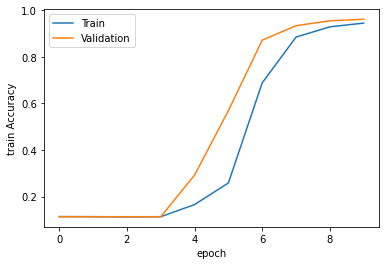

In [ ]:
sns.lineplot(x='epoch', y='train Accuracy', data=AlexNet_results, label='Train')
sns.lineplot(x='epoch', y='val Accuracy', data=AlexNet_results, label='Validation')

## VGG Network

Like AlexNet and LeNet, 
the VGG Network can be partitioned into two parts:
the first consisting mostly of convolutional and pooling layers and the second consisting of fully connected layers that are identical to those in AlexNet. 
The key difference is that the convolutional layers are grouped in nonlinear transformations that 
leave the dimensonality unchanged, followed by a resolution-reduction step, as 
depicted in the following figure. The idea of using blocks first emerged from the Visual Geometry Group (VGG) at Oxford University, in their eponymously-named *VGG* network.
It is easy to implement these repeated structures in code
with any modern deep learning framework by using loops and subroutines.
 

![From AlexNet to VGG. The key difference is that VGG consists of blocks of layers, whereas AlexNet's layers are all designed individually.](http://d2l.ai/_images/vgg.svg)
:width:`400px`
:label:`fig_vgg`

The convolutional part of the network connects several VGG blocks from :numref:`fig_vgg` (also defined in the `vgg_block` function)
in succession. This grouping of convolutions is a pattern that has 
remained almost unchanged over the past decade, although the specific choice of 
operations has undergone considerable modifications. 
The variable `conv_arch` consists of a list of tuples (one per block),
where each contains two values: the number of convolutional layers
and the number of output channels,
which are precisely the arguments required to call
the `vgg_block` function. As such, VGG defines a *family* of networks rather than just 
a specific manifestation. To build a specific network we simply iterate over `arch` to compose the blocks.


In [28]:
from d2l import torch as d2l

def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

In [29]:
class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

In [31]:
VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))).layer_summary(
    (1, 1, 224, 224))

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


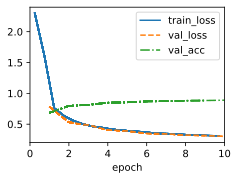

In [32]:
model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

## Network in Network (NiN)

LeNet, AlexNet, and VGG all share a common design pattern:
extract features exploiting *spatial* structure
via a sequence of convolutions and pooling layers
and post-process the representations via fully connected layers.
The improvements upon LeNet by AlexNet and VGG mainly lie
in how these later networks widen and deepen these two modules.

This design poses two major challenges.
First, the fully connected layers at the end
of the architecture consume tremendous numbers of parameters. For instance, even a simple
model such as VGG-11 requires a monstrous $25088 \times 4096$ matrix, occupying almost
400MB of RAM in single precision (FP32). This is a significant impediment to computation, in particular on
mobile and embedded devices. After all, even high-end mobile phones sport no more than 8GB of RAM. At the time VGG was invented, this was an order of magnitude less (the iPhone 4S had 512MB). As such, it would have been difficult to justify spending the majority of memory on an image classifier. 

Second, it is equally impossible to add fully connected layers
earlier in the network to increase the degree of nonlinearity: doing so would destroy the
spatial structure and require potentially even more memory.

The *network in network* (*NiN*) blocks :cite:`Lin.Chen.Yan.2013` offer an alternative,
capable of solving both problems in one simple strategy.
They were proposed based on a very simple insight: (i) use $1 \times 1$ convolutions to add
local nonlinearities across the channel activations and (ii) use global average pooling to integrate
across all locations in the last representation layer. Note that global average pooling would not
be effective, were it not for the added nonlinearities. Let's dive into this in detail.


### **NiN Blocks**

We discussed that the inputs and outputs of convolutional layers
consist of four-dimensional tensors with axes
corresponding to the example, channel, height, and width.
Also recall that the inputs and outputs of fully connected layers
are typically two-dimensional tensors corresponding to the example and feature.
The idea behind NiN is to apply a fully connected layer
at each pixel location (for each height and width).
The resulting $1 \times 1$ convolution can be thought as
a fully connected layer acting independently on each pixel location.

:numref:`fig_nin` illustrates the main structural
differences between VGG and NiN, and their blocks.
Note both the difference in the NiN blocks (the initial convolution is followed by $1 \times 1$ convolutions, whereas VGG retains $3 \times 3$ convolutions) and in the end where we no longer require a giant fully connected layer.

![Comparing the architectures of VGG and NiN, and of their blocks.](http://d2l.ai/_images/nin.svg)
:width:`600px`
:label:`fig_nin`

In [21]:
from d2l import torch as d2l

def nin_block(out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU())

In [22]:
class NiN(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nin_block(96, kernel_size=11, strides=4, padding=0),
            nn.MaxPool2d(3, stride=2),
            nin_block(256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nin_block(num_classes, kernel_size=3, strides=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten())
        self.net.apply(d2l.init_cnn)

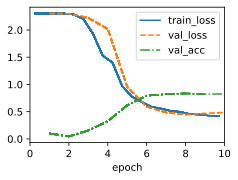

In [24]:
model = NiN(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

## GoogLeNet
In 2014, *GoogLeNet*
won the ImageNet Challenge :cite:`Szegedy.Liu.Jia.ea.2015`, using a structure
that combined the strengths of NiN :cite:`Lin.Chen.Yan.2013`, repeated blocks :cite:`Simonyan.Zisserman.2014`,
and a cocktail of convolution kernels. It is arguably also the first network that exhibits a clear distinction among the stem (data ingest), body (data processing), and head (prediction) in a CNN. This design pattern has persisted ever since in the design of deep networks: the *stem* is given by the first 2--3 convolutions that operate on the image. They extract low-level features from the underlying images. This is followed by a *body* of convolutional blocks. Finally, the *head* maps the features obtained so far to the required classification, segmentation, detection, or tracking problem at hand.

The key contribution in GoogLeNet was the design of the network body. It solved the problem of selecting
convolution kernels in an ingenious way. While other works tried to identify which convolution, ranging from $1 \times 1$ to $11 \times 11$ would be best, it simply *concatenated* multi-branch convolutions.
In what follows we introduce a slightly simplified version of GoogLeNet: the original design included a number of tricks to stabilize training through intermediate loss functions, applied to multiple layers of the network. 
They are no longer necessary due to the availability of improved training algorithms. 


## **Inception Blocks**

The basic convolutional block in GoogLeNet is called an *Inception block*,
stemming from the meme "we need to go deeper" of the movie *Inception*.

![Structure of the Inception block.](http://d2l.ai/_images/inception.svg)
:label:`fig_inception`

As depicted in :numref:`fig_inception`,
the inception block consists of four parallel branches.
The first three branches use convolutional layers
with window sizes of $1\times 1$, $3\times 3$, and $5\times 5$
to extract information from different spatial sizes.
The middle two branches also add a $1\times 1$ convolution of the input
to reduce the number of channels, reducing the model's complexity.
The fourth branch uses a $3\times 3$ max-pooling layer,
followed by a $1\times 1$ convolutional layer
to change the number of channels.
The four branches all use appropriate padding to give the input and output the same height and width.
Finally, the outputs along each branch are concatenated
along the channel dimension and comprise the block's output.
The commonly-tuned hyperparameters of the Inception block
are the number of output channels per layer, i.e., how to allocate capacity among convolutions of different size.


In [49]:
from d2l import torch as d2l


class Inception(nn.Module):
    # `c1`--`c4` are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)

## GoogLeNet Model

As shown in :numref:`fig_inception_full`, GoogLeNet uses a stack of a total of 9 inception blocks, arranged into 3 groups with max-pooling in between,
and global average pooling in its head to generate its estimates.
Max-pooling between inception blocks reduces the dimensionality.
At its stem, the first module is similar to AlexNet and LeNet.

![The GoogLeNet architecture.](http://d2l.ai/_images/inception-full-90.svg)

We can now implement GoogLeNet piece by piece. Let's begin with the stem.
The first module uses a 64-channel $7\times 7$ convolutional layer.

In [50]:
class GoogleNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The second module uses two convolutional layers:
first, a 64-channel $1\times 1$ convolutional layer,
followed by a $3\times 3$ convolutional layer that triples the number of channels. This corresponds to the second branch in the Inception block and concludes the design of the body. At this point we have 192 channels.

In [51]:
@d2l.add_to_class(GoogleNet)
def b2(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The third module connects two complete Inception blocks in series.
The number of output channels of the first Inception block is
$64+128+32+32=256$. This amounts to 
a ratio of the number of output channels
among the four branches of $2:4:1:1$. Achieving this, we first reduce the input
dimensions by $\frac{1}{2}$ and by $\frac{1}{12}$ in the second and third branch respectively
to arrive at $96 = 192/2$ and $16 = 192/12$ channels respectively.

The number of output channels of the second Inception block
is increased to $128+192+96+64=480$, yielding a ratio of $128:192:96:64 = 4:6:3:2$. As before,
we need to reduce the number of intermediate dimensions in the second and third channel. A
scale of $\frac{1}{2}$ and $\frac{1}{8}$ respectively suffices, yielding $128$ and $32$ channels
respectively. This is captured by the arguments of the following `Inception` block constructors.

In [52]:
@d2l.add_to_class(GoogleNet)
def b3(self):
    return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                         Inception(128, (128, 192), (32, 96), 64),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The fourth module is more complicated.
It connects five Inception blocks in series,
and they have $192+208+48+64=512$, $160+224+64+64=512$,
$128+256+64+64=512$, $112+288+64+64=528$,
and $256+320+128+128=832$ output channels, respectively.
The number of channels assigned to these branches is similar
to that in the third module:
the second branch with the $3\times 3$ convolutional layer
outputs the largest number of channels,
followed by the first branch with only the $1\times 1$ convolutional layer,
the third branch with the $5\times 5$ convolutional layer,
and the fourth branch with the $3\times 3$ max-pooling layer.
The second and third branches will first reduce
the number of channels according to the ratio.
These ratios are slightly different in different Inception blocks.


In [53]:
@d2l.add_to_class(GoogleNet)
def b4(self):
    return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                         Inception(160, (112, 224), (24, 64), 64),
                         Inception(128, (128, 256), (24, 64), 64),
                         Inception(112, (144, 288), (32, 64), 64),
                         Inception(256, (160, 320), (32, 128), 128),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The fifth module has two Inception blocks with $256+320+128+128=832$
and $384+384+128+128=1024$ output channels.
The number of channels assigned to each branch
is the same as that in the third and fourth modules,
but differs in specific values.
It should be noted that the fifth block is followed by the output layer.
This block uses the global average pooling layer
to change the height and width of each channel to 1, just as in NiN.
Finally, we turn the output into a two-dimensional array
followed by a fully connected layer
whose number of outputs is the number of label classes.

In [54]:
@d2l.add_to_class(GoogleNet)
def b5(self):
    return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                         Inception(384, (192, 384), (48, 128), 128),
                         nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())

In [55]:
@d2l.add_to_class(GoogleNet)
def __init__(self, lr=0.1, num_classes=10):
    super(GoogleNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                             self.b5(), nn.LazyLinear(num_classes))
    self.net.apply(d2l.init_cnn)

In [ ]:
print_dim(GoogleNet(), 224)

Sequential output shape: 	 torch.Size([1, 64, 56, 56])
Sequential output shape: 	 torch.Size([1, 192, 28, 28])
Sequential output shape: 	 torch.Size([1, 480, 14, 14])
Sequential output shape: 	 torch.Size([1, 832, 7, 7])
Sequential output shape: 	 torch.Size([1, 1024])
Linear output shape: 	 torch.Size([1, 10])


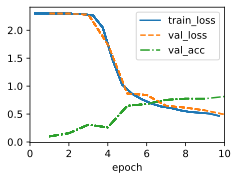

In [56]:
googlenet_model = GoogleNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
googlenet_model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(googlenet_model, data)

## Residual Blocks

Let's focus on a local part of a neural network, as depicted in :numref:`fig_residual_block`. Denote the input by $\mathbf{x}$.
We assume that the desired underlying mapping we want to obtain by learning is $f(\mathbf{x})$, to be used as input to the activation function on the top.
On the left,
the portion within the dotted-line box
must directly learn the mapping $f(\mathbf{x})$.
On the right,
the portion within the dotted-line box
needs to
learn the *residual mapping* $g(\mathbf{x}) = f(\mathbf{x}) - \mathbf{x}$,
which is how the residual block derives its name.
If the identity mapping $f(\mathbf{x}) = \mathbf{x}$ is the desired underlying mapping,
the residual mapping amounts to $g(\mathbf{x}) = 0$ and it is thus easier to learn:
we only need to push the weights and biases
of the
upper weight layer (e.g., fully connected layer and convolutional layer)
within the dotted-line box
to zero.
The right figure illustrates the *residual block* of ResNet,
where the solid line carrying the layer input
$\mathbf{x}$ to the addition operator
is called a *residual connection* (or *shortcut connection*).
With residual blocks, inputs can
forward propagate faster through the residual connections across layers.
In fact,
the residual block
can be thought of as
a special case of the multi-branch Inception block:
it has two branches
one of which is the identity mapping.

![In a regular block (left), the portion within the dotted-line box must directly learn the mapping $f(\mathbf{x})$. In a residual block (right), the portion within the dotted-line box needs to learn the residual mapping $g(\mathbf{x}) = f(\mathbf{x}) - \mathbf{x}$, making the identity mapping $f(\mathbf{x}) = \mathbf{x}$ easier to learn.](http://d2l.ai/_images/residual-block.svg)


ResNet follows VGG's full $3\times 3$ convolutional layer design. The residual block has two $3\times 3$ convolutional layers with the same number of output channels. Each convolutional layer is followed by a batch normalization layer and a ReLU activation function. Then, we skip these two convolution operations and add the input directly before the final ReLU activation function.
This kind of design requires that the output of the two convolutional layers has to be of the same shape as the input, so that they can be added together. If we want to change the number of channels, we need to introduce an additional $1\times 1$ convolutional layer to transform the input into the desired shape for the addition operation. Let's have a look at the code below.


In [ ]:
class Residual(nn.Module):
    """The Residual block of ResNet."""
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

This code generates two types of networks: one where we add the input to the output before applying the ReLU nonlinearity whenever `use_1x1conv=False`, and one where we adjust channels and resolution by means of a $1 \times 1$ convolution before adding. :numref:`fig_resnet_block` illustrates this.

![ResNet block with and without $1 \times 1$ convolution, which transforms the input into the desired shape for the addition operation.](http://d2l.ai/_images/resnet-block.svg)
:label:`fig_resnet_block`

Now let's look at [**a situation where the input and output are of the same shape**], where $1 \times 1$ convolution is not needed.

## ResNet Model

The first two layers of ResNet are the same as those of the GoogLeNet we described before: the $7\times 7$ convolutional layer with 64 output channels and a stride of 2 is followed by the $3\times 3$ max-pooling layer with a stride of 2. The difference is the batch normalization layer added after each convolutional layer in ResNet.

In [ ]:
b1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

GoogLeNet uses four modules made up of Inception blocks.
However, ResNet uses four modules made up of residual blocks, each of which uses several residual blocks with the same number of output channels.
The number of channels in the first module is the same as the number of input channels. Since a max-pooling layer with a stride of 2 has already been used, it is not necessary to reduce the height and width. In the first residual block for each of the subsequent modules, the number of channels is doubled compared with that of the previous module, and the height and width are halved.

In [ ]:
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels,))
    return blk

Then, we add all the modules to ResNet. Here, two residual blocks are used for each module. Lastly, just like GoogLeNet, we add a global average pooling layer, followed by the fully connected layer output.

In [ ]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [ ]:
ResNet = nn.Sequential(b1, b2, b3, b4, b5, nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(), nn.Linear(512, 10))

There are 4 convolutional layers in each module (excluding the $1\times 1$ convolutional layer). Together with the first $7\times 7$ convolutional layer and the final fully connected layer, there are 18 layers in total. Therefore, this model is commonly known as ResNet-18.
By configuring different numbers of channels and residual blocks in the module, we can create different ResNet models, such as the deeper 152-layer ResNet-152. Although the main architecture of ResNet is similar to that of GoogLeNet, ResNet's structure is simpler and easier to modify. All these factors have resulted in the rapid and widespread use of ResNet. :numref:`fig_resnet18` depicts the full ResNet-18.

![The ResNet-18 architecture.](http://d2l.ai/_images/resnet18-90.svg)
:label:`fig_resnet18`

Before training ResNet, let's [**observe how the input shape changes across different modules in ResNet**]. As in all the previous architectures, the resolution decreases while the number of channels increases up until the point where a global average pooling layer aggregates all features.

In [ ]:
loss_func = nn.CrossEntropyLoss()
ResNet_results = train_simple_network(ResNet, loss_func, mnist_train_loader, val_loader=mnist_test_loader, 
                                   score_funcs={'Accuracy': accuracy_score}, device=device, epochs=5, lr=0.01)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

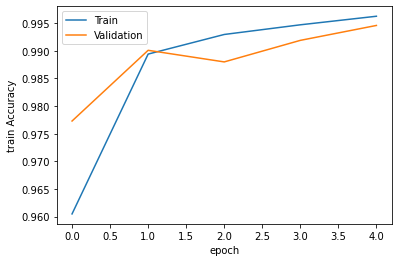

In [ ]:
sns.lineplot(x='epoch', y='train Accuracy', data=ResNet_results, label='Train')
sns.lineplot(x='epoch', y='val Accuracy', data=ResNet_results, label='Validation')

## ResNeXt
:label:`subsec_resnext`

One of the challenges one encounters in the design of ResNet is the trade-off between nonlinearity and dimensionality within a given block. That is, we could add more nonlinearity by increasing the number of layers, or by increasing the width of the convolutions. An alternative strategy is to increase the number of channels that can carry information between blocks. Unfortunately, the latter comes with a quadratic penalty since the computational cost of ingesting $c_i$ channels and emitting $c_o$ channels is proportional to $\mathcal{O}(c_i \cdot c_o)$ (see our discussion in :numref:`sec_channels`). 

We can take some inspiration from the Inception block of :numref:`fig_inception` which has information flowing through the block in separate groups. Applying the idea of multiple independent groups to the ResNet block of :numref:`fig_resnet_block` led to the design of ResNeXt :cite:`Xie.Girshick.Dollar.ea.2017`.
Different from the smorgasbord of transformations in Inception, 
ResNeXt adopts the *same* transformation in all branches,
thus minimizing the need for manual tuning of each branch. 

![The ResNeXt block. The use of grouped convolution with $g$ groups is $g$ times faster than a dense convolution. It is a bottleneck residual block when the number of intermediate channels $b$ is less than $c$.](http://d2l.ai/_images/resnext-block.svg)
:label:`fig_resnext_block`

Breaking up a convolution from $c_i$ to $c_o$ channels into one of $g$ groups of size $c_i/g$ generating $g$ outputs of size $c_o/g$ is called, quite fittingly, a *grouped convolution*. The computational cost (proportionally) is reduced from $\mathcal{O}(c_i \cdot c_o)$ to $\mathcal{O}(g \cdot (c_i/g) \cdot (c_o/g)) = \mathcal{O}(c_i \cdot c_o / g)$, i.e., it is $g$ times faster. Even better, the number of parameters needed to generate the output is also reduced from a $c_i \times c_o$ matrix to $g$ smaller matrices of size $(c_i/g) \times (c_o/g)$, again a $g$ times reduction. In what follows we assume that both $c_i$ and $c_o$ are divisible by $g$. 

The only challenge in this design is that no information is exchanged between the $g$ groups. The ResNeXt block of 
:numref:`fig_resnext_block` amends this in two ways: the grouped convolution with a $3 \times 3$ kernel is sandwiched in between two $1 \times 1$ convolutions. The second one serves double duty in changing the number of channels back. The benefit is that we only pay the $\mathcal{O}(c \cdot b)$ cost for $1 \times 1$ kernels and can make do with an $\mathcal{O}(b^2 / g)$ cost for $3 \times 3$ kernels. Similar to the residual block implementation in
:numref:`subsec_residual-blks`, the residual connection is replaced (thus generalized) by a $1 \times 1$ convolution.

The right figure in :numref:`fig_resnext_block` provides a much more concise summary of the resulting network block. It will also play a major role in the design of generic modern CNNs in :numref:`sec_cnn-design`. Note that the idea of grouped convolutions dates back to the implementation of AlexNet :cite:`Krizhevsky.Sutskever.Hinton.2012`. When distributing the network across two GPUs with limited memory, the implementation treated each GPU as its own channel with no ill effects. 

The following implementation of the `ResNeXtBlock` class takes as argument `groups` ($g$), with 
`bot_channels` ($b$) intermediate (bottleneck) channels. Lastly, when we need to reduce the height and width of the representation, we add a stride of $2$ by setting `use_1x1conv=True, strides=2`.


In [ ]:
class ResNeXtBlock(nn.Module):
    """The ResNeXt block."""
    def __init__(self, num_channels, groups, bot_mul, use_1x1conv=False,
                 strides=1):
        super().__init__()
        bot_channels = int(round(num_channels * bot_mul))
        self.conv1 = nn.LazyConv2d(bot_channels, kernel_size=1, stride=1)
        self.conv2 = nn.LazyConv2d(bot_channels, kernel_size=3,
                                   stride=strides, padding=1,
                                   groups=bot_channels//groups)
        self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=1)
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
        self.bn3 = nn.LazyBatchNorm2d()
        if use_1x1conv:
            self.conv4 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
            self.bn4 = nn.LazyBatchNorm2d()
        else:
            self.conv4 = None

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn2(self.conv2(Y)))
        Y = self.bn3(self.conv3(Y))
        if self.conv4:
            X = self.bn4(self.conv4(X))
        return F.relu(Y + X)

# Densely Connected Networks (DenseNet)
:label:`sec_densenet`

ResNet significantly changed the view of how to parametrize the functions in deep networks. *DenseNet* (dense convolutional network) is to some extent the logical extension of this :cite:`Huang.Liu.Van-Der-Maaten.ea.2017`.
DenseNet is characterized by both the connectivity pattern where
each layer connects to all the preceding layers
and the concatenation operation (rather than the addition operator in ResNet) to preserve and reuse features
from earlier layers.
To understand how to arrive at it, let's take a small detour to mathematics.


## From ResNet to DenseNet

Recall the Taylor expansion for functions. For the point $x = 0$ it can be written as

$$f(x) = f(0) + x \cdot \left[f'(0) + x \cdot \left[\frac{f''(0)}{2!}  + x \cdot \left[\frac{f'''(0)}{3!}  + \ldots \right]\right]\right].$$


The key point is that it decomposes a function into increasingly higher order terms. In a similar vein, ResNet decomposes functions into

$$f(\mathbf{x}) = \mathbf{x} + g(\mathbf{x}).$$

That is, ResNet decomposes $f$ into a simple linear term and a more complex
nonlinear one.
What if we wanted to capture (not necessarily add) information beyond two terms?
One such solution is DenseNet :cite:`Huang.Liu.Van-Der-Maaten.ea.2017`.

![The main difference between ResNet (left) and DenseNet (right) in cross-layer connections: use of addition and use of concatenation. ](http://d2l.ai/_images/densenet-block.svg)
:label:`fig_densenet_block`

As shown in :numref:`fig_densenet_block`, the key difference between ResNet and DenseNet is that in the latter case outputs are *concatenated* (denoted by $[,]$) rather than added.
As a result, we perform a mapping from $\mathbf{x}$ to its values after applying an increasingly complex sequence of functions:

$$\mathbf{x} \to \left[
\mathbf{x},
f_1(\mathbf{x}),
f_2\left(\left[\mathbf{x}, f_1\left(\mathbf{x}\right)\right]\right), f_3\left(\left[\mathbf{x}, f_1\left(\mathbf{x}\right), f_2\left(\left[\mathbf{x}, f_1\left(\mathbf{x}\right)\right]\right)\right]\right), \ldots\right].$$

In the end, all these functions are combined in MLP to reduce the number of features again. In terms of implementation this is quite simple:
rather than adding terms, we concatenate them. The name DenseNet arises from the fact that the dependency graph between variables becomes quite dense. The last layer of such a chain is densely connected to all previous layers. The dense connections are shown in :numref:`fig_densenet`.

![Dense connections in DenseNet. Note how the dimensionality increases with depth.](http://d2l.ai/_images/densenet.svg)
:label:`fig_densenet`

The main components that compose a DenseNet are *dense blocks* and *transition layers*. The former define how the inputs and outputs are concatenated, while the latter control the number of channels so that it is not too large, 
since the expansion $\mathbf{x} \to \left[\mathbf{x}, f_1(\mathbf{x}),
f_2\left(\left[\mathbf{x}, f_1\left(\mathbf{x}\right)\right]\right), \ldots \right]$ can be quite high-dimensional.


## [**Dense Blocks**]

DenseNet uses the modified "batch normalization, activation, and convolution"
structure of ResNet (see the exercise in :numref:`sec_resnet`).
First, we implement this convolution block structure.


In [ ]:
def conv_block(input_channels ,num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

In [ ]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels*i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate input and output of each block along the channels
            X = torch.cat((X, Y), dim=1)
        return X

In the following example,
we [**define a `DenseBlock` instance**] with 2 convolution blocks of 10 output channels.
When using an input with 3 channels, we will get an output with  $3 + 10 + 10=23$ channels. The number of convolution block channels controls the growth in the number of output channels relative to the number of input channels. This is also referred to as the *growth rate*.

In [ ]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

## [**Transition Layers**]

Since each dense block will increase the number of channels, adding too many of them will lead to an excessively complex model. A *transition layer* is used to control the complexity of the model. It reduces the number of channels by using an $1\times 1$ convolution. Moreover, it halves the height and width via average pooling with a stride of 2.

In [ ]:
def transition_block(input_channels ,num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

[**Apply a transition layer**] with 10 channels to the output of the dense block in the previous example.  This reduces the number of output channels to 10, and halves the height and width.

In [ ]:
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

## [**DenseNet Model**]

Next, we will construct a DenseNet model. DenseNet first uses the same single convolutional layer and max-pooling layer as in ResNet.

In [ ]:
b1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

Then, similar to the four modules made up of residual blocks that ResNet uses,
DenseNet uses four dense blocks.
Similar to ResNet, we can set the number of convolutional layers used in each dense block. Here, we set it to 4, consistent with the ResNet-18 model in :numref:`sec_resnet`. Furthermore, we set the number of channels (i.e., growth rate) for the convolutional layers in the dense block to 32, so 128 channels will be added to each dense block.

In ResNet, the height and width are reduced between each module by a residual block with a stride of 2. Here, we use the transition layer to halve the height and width and halve the number of channels. Similar to ResNet, a global pooling layer and a fully connected layer are connected at the end to produce the output.

In [ ]:
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
  blks.append(DenseBlock(num_convs, num_channels, growth_rate))
  num_channels += num_convs*growth_rate
  if i != len(num_convs_in_dense_blocks) - 1:
    blks.append(transition_block(num_channels, num_channels//2))
    num_channels = num_channels//2
    


Similar to ResNet, a global pooling layer and a fully-connected layer are connected at the end to produce the output.

In [ ]:
Dense_Net = nn.Sequential(
    b1, *blks, nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
    nn.Linear(num_channels, 10)
)

In [ ]:
loss_func = nn.CrossEntropyLoss()
DenseNet_results = train_simple_network(Dense_Net, loss_func, mnist_train_loader, val_loader=mnist_test_loader, 
                                   score_funcs={'Accuracy': accuracy_score}, device=device, epochs=5, lr=0.01)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1875 [00:00<?, ?it/s]

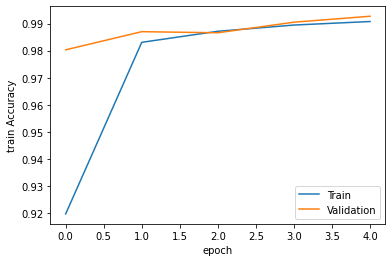

In [ ]:
sns.lineplot(x='epoch', y='train Accuracy', data=DenseNet_results, label='Train')
sns.lineplot(x='epoch', y='val Accuracy', data=DenseNet_results, label='Validation')

## The AnyNet Design Space

The initial design space is called *AnyNet*,
a relatively unconstrained design space,
where we can focus on
exploring network structure
assuming standard, fixed blocks such as ResNeXt (:numref:`subsec_resnext`).
Specifically,
the network structure
includes
elements
such as the number of blocks
and the number of output channels
in each stage,
and the number of groups (group width) and bottleneck ratio
within
each ResNeXt block.



![The AnyNet design space. Besides the number of groups and bottleneck ratio within each block, design choices include depth $d_i$ and the number of output channels $w_i$ for any stage $i$.](http://d2l.ai/_images/anynet.svg)
:label:`fig_anynet`

The AnyNet design space
is shown in :numref:`fig_anynet`.
This network
begins with a *stem*,
followed by a *body* with $n$ stages of transformation,
and a final *head*.
More concretely,
the network stem
is a $3 \times 3$ convolution with stride 2
that halves the height and width of an input image.
The network head
is a global average pooling followed
by a fully connected layer to predict
the output class.
Note that
the network stem and head
are kept fixed and simple,
so that the design focus in
on the network body that is central
to performance.
Specifically,
the network body
consists of $n$ stages of transformation
($n$ is given),
where stage $i$
consists of $d_i$ ResNeXt blocks
with $w_i$ output channels,
and progressively
halves height and width via the first block
(setting `use_1x1conv=True, strides=2` in `d2l.ResNeXtBlock` in :numref:`subsec_resnext`).
Let's further
denote
the bottleneck ratio and
the number of groups (group width)
within
each ResNeXt block for stage $i$
as $b_i$ and $g_i$, respectively.
Overall,
despite of the straightforward network structure,
varying $b_i$, $g_i$, $w_i$, and $d_i$
results in
a vast number of
possible networks in the AnyNet design space.


To implement AnyNet,
we first define its network stem.


In [ ]:
!pip install d2l==1.0.0-alpha1.post0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 962 kB/s 
     |████████████████████████████████| 120 kB 28.4 MB/s 
     |████████████████████████████████| 1.6 MB 61.3 MB/s 
     |████████████████████████████████| 82 kB 874 kB/s 


In [ ]:
from d2l import torch as d2l

class AnyNet(d2l.Classifier):
    def stem(self, num_channels):
        return nn.Sequential(
            nn.LazyConv2d(num_channels, kernel_size=3, stride=2, padding=1),
            nn.LazyBatchNorm2d(), nn.ReLU())

In [ ]:
@d2l.add_to_class(AnyNet)
def stage(self, depth, num_channels, groups, bot_mul):
    blk = []
    for i in range(depth):
        if i == 0:
            blk.append(d2l.ResNeXtBlock(num_channels, groups, bot_mul,
                use_1x1conv=True, strides=2))
        else:
            blk.append(d2l.ResNeXtBlock(num_channels, groups, bot_mul))
    return nn.Sequential(*blk)

Putting the network stem, body, and head together,
we complete the implementation of AnyNet.

In [ ]:
@d2l.add_to_class(AnyNet)
def __init__(self, arch, stem_channels, lr=0.1, num_classes=10):
    super(AnyNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.stem(stem_channels))
    for i, s in enumerate(arch):
        self.net.add_module(f'stage{i+1}', self.stage(*s))
    self.net.add_module('head', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

## Constraining Design Spaces with Lower Error Distributions

For any stage $i$ of AnyNet,
the design choices are
the bottleneck ratio $b_i$
and the number of groups $g_i$
within each block,
block width $w_i$,
and depth $d_i$.
The designing network design spaces
process starts
from relatively unconstrained
network structure characterized
by ($b_i$, $g_i$, $w_i$, $d_i$)
in the initial AnyNet design space.
Then this process
progressively samples models
from the input design space
to evaluate the error distribution :cite:`radosavovic2019network`
as a quality indicator
to output a more constrained
design space with simpler models that may have
better quality.

Let's detail
this quality indicator for design spaces.
Given $n$ models sampled from some design space,
the *error empirical distribution function* $F(e)$
measures the fraction of models
with errors $e_i$ lower than $e$:

$$F(e) = \frac{1}{n}\sum_{i=1}^n \mathbf{1}(e_i < e).$$


Starting from the initial unconstrained AnyNet design space ($\text{AnyNetX}_A$ in :citet:`Radosavovic.Kosaraju.Girshick.ea.2020`),
sharing the bottle network ratio $b_i = b$ for all stages $i$ results in a more constrained design space $\text{AnyNetX}_B$.
Sampling and training $n=500$ models from $\text{AnyNetX}_A$ and $\text{AnyNetX}_B$ each,
left of :numref:`fig_regnet-paper-fig5`
shows that both design spaces have similar quality.
Since simpler is better,
we continue to search from $\text{AnyNetX}_B$
by additionally sharing the number of groups $g_i = g$.
This leads to a further simplified design space
$\text{AnyNetX}_C$ with virtually no change
in error distributions (right of :numref:`fig_regnet-paper-fig5`).

![Comparing error empirical distribution functions of design spaces. The legends show the min error and mean error. Sharing bottleneck ratio (from $\text{AnyNetX}_A$ to  $\text{AnyNetX}_B$) and sharing the number of groups (from $\text{AnyNetX}_B$ to $\text{AnyNetX}_C$) simplify the design space with virtually no change in error distributions (figure taken from :citet:`Radosavovic.Kosaraju.Girshick.ea.2020`).](http://d2l.ai/_images/regnet-paper-fig5.png)
:width:`600px`
:label:`fig_regnet-paper-fig5`

Investigating good and bad models from $\text{AnyNetX}_C$ suggests that it may be useful to increase width across stages :cite:`Radosavovic.Kosaraju.Girshick.ea.2020`.
Empirically, simplifying
$\text{AnyNetX}_C$ to $\text{AnyNetX}_D$
with $w_{i} \leq w_{i+1}$
improves the quality of design spaces (left of  :numref:`fig_regnet-paper-fig7`).
Similarly,
adding further constraints of $d_{i} \leq d_{i+1}$
to increase network depth across stages
gives an even better $\text{AnyNetX}_E$
(right of :numref:`fig_regnet-paper-fig7`).

![Comparing error empirical distribution functions of design spaces. The legends show the min error and mean error. Increasing network width across stages (from $\text{AnyNetX}_C$ to  $\text{AnyNetX}_D$) and increasing network depth across stages (from $\text{AnyNetX}_D$ to $\text{AnyNetX}_E$) simplify the design space with improved  error distributions (figure taken from :citet:`Radosavovic.Kosaraju.Girshick.ea.2020`).](http://d2l.ai/_images/regnet-paper-fig7.png)
:width:`600px`
:label:`fig_regnet-paper-fig7`



## RegNet

The resulting $\text{AnyNetX}_E$ design space
consists of simple networks
following easy-to-interpret design principles:

* Share the bottle network ratio $b_i = b$ for all stages $i$;
* Share the number of groups $g_i = g$ for all stages $i$;
* Increase network width across stages: $w_{i} \leq w_{i+1}$;
* Increase network depth across stages: $d_{i} \leq d_{i+1}$.

Following these design principles, :cite:`Radosavovic.Kosaraju.Girshick.ea.2020` proposed quantized linear constraints to
$w_i$ and $d_i$ increasing,
leading to
RegNetX using ResNeXt blocks
and RegNetY that additionally uses operators from SENets :cite:`Hu.Shen.Sun.2018`.
As an example,
we implement a 32-layer RegNetX variant
characterized by

* $b_i = 1;$
* $g_i = 16;$
* $w_1 = 32, w_2=80;$
* $d_1 = 4, d_2=6.$


In [ ]:
class RegNet32(AnyNet):
    def __init__(self, lr=0.1, num_classes=10):
        stem_channels, groups, bot_mul = 32, 16, 1
        depths, channels = (4, 6), (32, 80)
        super().__init__(
            ((depths[0], channels[0], groups, bot_mul),
             (depths[1], channels[1], groups, bot_mul)),
            stem_channels, lr, num_classes)

In [ ]:
RegNet32().layer_summary((1, 1, 96, 96))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Sequential output shape:	 torch.Size([1, 32, 48, 48])
Sequential output shape:	 torch.Size([1, 32, 24, 24])
Sequential output shape:	 torch.Size([1, 80, 12, 12])
Sequential output shape:	 torch.Size([1, 10])


Training the 32-layer RegNet on the Fashion-MNIST dataset

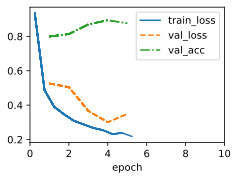

In [ ]:
model = RegNet32(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer.fit(model, data)